# Problem: Scraping data from Inshorts and using that data to classify general news

## Classifying news in 5 categories

## Likhit Jha 

In [ ]:
from selenium import webdriver

In [ ]:
import matplotlib.pyplot as plt
import re
import numpy as np

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt')


In [ ]:
# Importing 
import pandas as pd
#The One-vs-Rest strategy splits a multi-class classification into one binary classification problem per class.
from sklearn.multiclass import OneVsRestClassifier

# classifers being used
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

#importing word cloud for visualisation 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# for train test-test classifier
from sklearn.model_selection import train_test_split
# for accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

### Out of the several categories in Inhorts, we select these 5 categories,
### We will be scraping the news card content from the inshorts website

Science

Sports

Politics

Entertainment

Business

In [ ]:
## Use the scraping code to scrape and store data from each category one by one

### SCRAPING DATA FROM INSHORTS

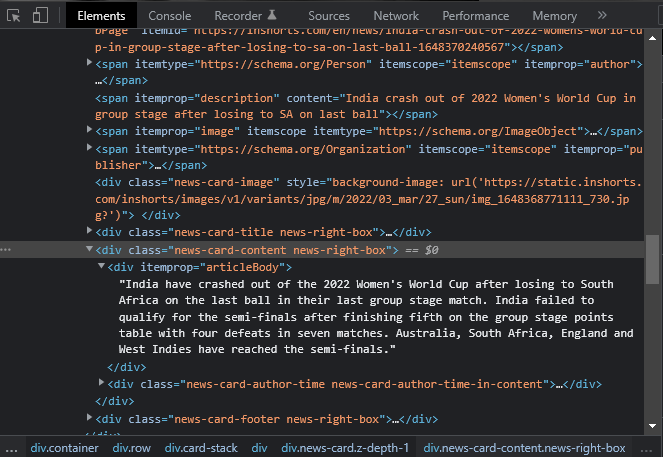
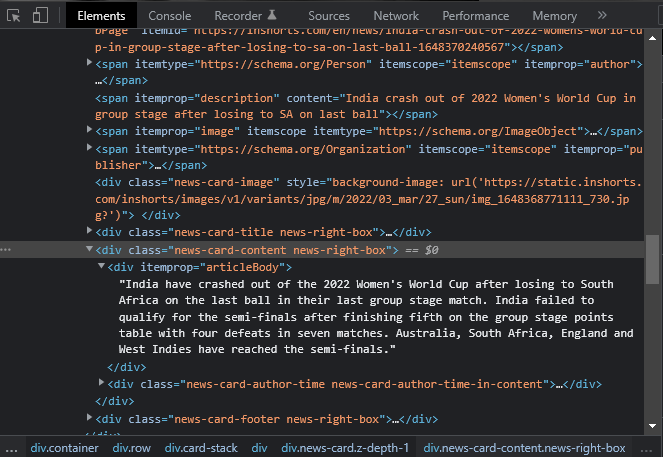

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
#Set cat, it is a string that takes in category of news 
cat='business'



df1 = pd.DataFrame(columns = ['Title', 'Content'])
def print_headlines(response_text):
    import time
    df = pd.DataFrame(columns = ['Title', 'Content'])
    soup = BeautifulSoup(response_text, 'lxml')
    newsCards = soup.find_all(class_='news-card')
    newsDictionary = {
        'success': True,
        'data': []
    }
    i=0
    for card in newsCards:
        try:
            title = card.find(class_='news-card-title').find('a').text
        except AttributeError:
            title = None

        try:
            imageUrl = card.find(
                class_='news-card-image')['style'].split("'")[1]
        except AttributeError:
            imageUrl = None

        try:
            url = ('https://www.inshorts.com' + card.find(class_='news-card-title')
                   .find('a').get('href'))
        except AttributeError:
            url = None

        try:
            content = card.find(class_='news-card-content').find('div').text
        except AttributeError:
            content = None

        try:
            author = card.find(class_='author').text
        except AttributeError:
            author = None

        try:
            date = card.find(clas='date').text
        except AttributeError:
            date = None

        try:
            time = card.find(class_='time').text
        except AttributeError:
            time = None

        try:
            readMoreUrl = card.find(class_='read-more').find('a').get('href')
        except AttributeError:
            readMoreUrl = None

        newsObject = {
            'title': title,
            'content': content,
        }
        print(newsObject['title'])
        df = df.append({'Title' : newsObject['title'], 'Content' : newsObject['content'] , 'Category' : cat}, 
                ignore_index = True)
        newsDictionary['data'].append(newsObject)
    #print(newsDictionary['data'])
    print(df)
    return df


def get_headers(): #specified in the network section
    return {
        "accept": "*/*",
        "accept-encoding": "gzip, deflate, br",
        "accept-language": "en-IN,en-US;q=0.9,en;q=0.8",
        "content-type": "application/x-www-form-urlencoded; charset=UTF-8",
        "cookie": "_ga=GA1.2.474379061.1548476083; _gid=GA1.2.251903072.1548476083; __gads=ID=17fd29a6d34048fc:T=1548476085:S=ALNI_MaRiLYBFlMfKNMAtiW0J3b_o0XGxw",
        "origin": "https://inshorts.com",
        "referer": "https://www.inshorts.com/en/read/"+cat,
        "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36",
        "x-requested-with": "XMLHttpRequest"
    }


url = 'https://inshorts.com/en/read/'+cat
response = requests.get(url)
print_headlines(response.text)

# get more news
url = 'https://inshorts.com/en/ajax/more_news'
news_offset = "06ir0ujk-1"     #change the offset acording to the offset specified for that category

while True:
    response = requests.post(url, data={"category": cat, "news_offset": news_offset}, headers=get_headers())
    if response.status_code != 200:
        print(response.status_code)
        break

    response_json = json.loads(response.text)
    df1=df1.append(print_headlines(response_json["html"]))
    news_offset = response_json["min_news_id"]

### Storing the data 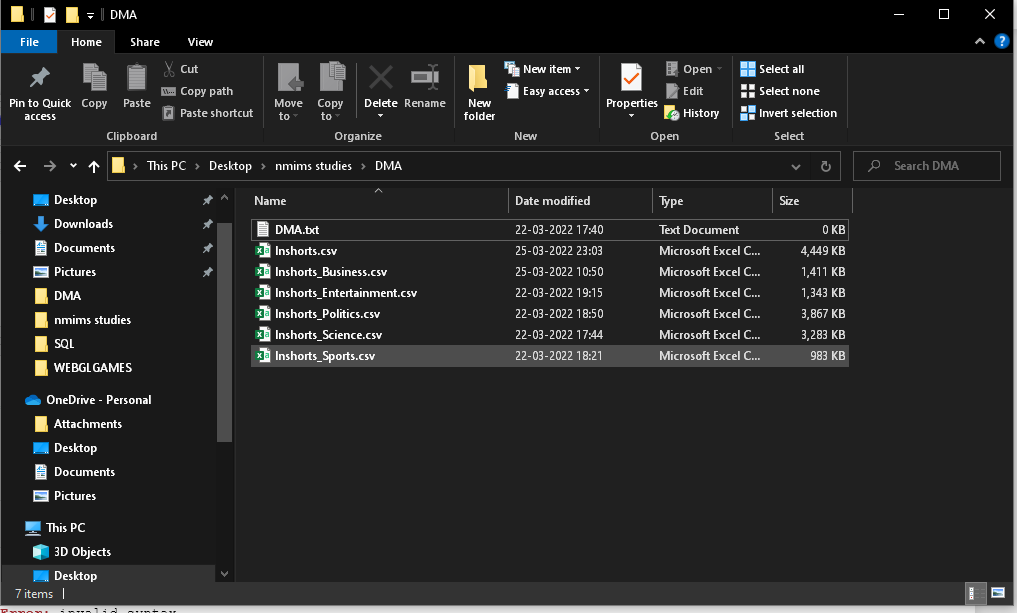

In [ ]:
#CSV TO DF

news={1:"Business",2:"Entertainment",3:"Politics",4:"Science",5:"Sports"}

for i in range(1,6):
    locals()["df"+news[i]] = pd.read_csv("C:\\Users\\likhi\\OneDrive\\Desktop\\nmims studies\\DMA\\Inshorts_"+news[i]+".csv")
    if "index" in locals()["df"+news[i]]:
        locals()["df"+news[i]]=locals()["df"+news[i]].drop(["index"],axis=1)
    if "Unnamed: 0" in locals()["df"+news[i]]:
        locals()["df"+news[i]]=locals()["df"+news[i]].drop(["Unnamed: 0"],axis=1)

In [ ]:
#Combining all the dataframes in one dataframe with equal proportion
dfInshorts = pd.concat([dfScience.head(2000), dfSports.head(2000), dfPolitics.head(2000), dfEntertainment.head(2000), dfBusiness.head(2000)], axis=0,ignore_index=True)


In [ ]:
dfInshorts

## Visualizing the data


### We want to check the frequency of words and the type oof words in each category. We do this using word cloud 

In [ ]:
from wordcloud import WordCloud

stop = set(stopwords.words('english'))

science = dfInshorts[dfInshorts['Category'] == 'science']
science = science['Content']

sports = dfInshorts[dfInshorts['Category'] == 'sports']
sports = sports['Content']

politics = dfInshorts[dfInshorts['Category'] == 'politics']
politics = politics['Content']

business = dfInshorts[dfInshorts['Category'] == 'business']
business = business['Content']

entertainment = dfInshorts[dfInshorts['Category'] == 'entertainment']
entertainment = entertainment['Content']

def wordcloud_draw(dataset, color = 'white'):
    words = ' '.join(dataset)
    cleaned_word = ' '.join([word for word in words.split() if (word != 'news' and word != 'text')])
    wordcloud = WordCloud(stopwords = stop, background_color = color, width = 3000, height = 2500).generate(cleaned_word)
    plt.figure(1, figsize = (15,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

print("business words:")
wordcloud_draw(business, 'white')

print("science words:")
wordcloud_draw(science, 'white')

print("politics words:")
wordcloud_draw(politics, 'white')

print("sports words:")
wordcloud_draw(sports, 'white')

print("entertainment words:")
wordcloud_draw(entertainment, 'white')

## Cleaning and preparing the dataset for classification 

In [ ]:
#used regex

def remove_tags(text):
    remove = re.compile(r'')
    return re.sub(remove, '', text)
dfInshorts['Content'] = dfInshorts['Content'].apply(remove_tags)


In [ ]:
dfInshorts['Content'].head(10)

In [ ]:
def convert_lower_remove_special_char(text):
    reviews = ''
    if type(text) is not int:
        for x in text:
            if x.isalnum():
                
                  reviews = reviews + x
            else:
                  reviews = reviews + ' '
                    
        reviews=reviews.lower()
        
                    
    return reviews
dfInshorts['Content'] = dfInshorts['Content'].apply(convert_lower_remove_special_char)

In [ ]:
#Joining again
for i in range(0,len(dfInshorts['Content'])):
    dfInshorts['Content'][i]=" ".join(dfInshorts['Content'][i].split())


In [ ]:
dfInshorts['Content'].head(20)

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]
dfInshorts['Content'] = dfInshorts['Content'].apply(remove_stopwords)
dfInshorts['Content'][1]

In [ ]:
dfInshorts['Content']

In [ ]:
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])
dfInshorts['Content'] = dfInshorts['Content'].apply(lemmatize_word)
dfInshorts['Content'][1]

In [ ]:
dfInshorts['Content']

In [ ]:
#Creating a fit bag of words
from sklearn.feature_extraction.text import CountVectorizer
x = np.array(dfInshorts.Content.values)
y = np.array(dfInshorts.Category.values)
cv = CountVectorizer(max_features = 5000) #TOP 5000 words marked with 1 if occured in a (row) sentence
x = cv.fit_transform(dfInshorts.Content).toarray() 
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

## Splitting data, Train and Test

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train))
print(len(x_test))

## Now we are ready to train the model 

Used a one vs all approach for all the models, as the computation time and the complexity is quiet lower compared to one vs one.

Random Forest,
Multinomial Naive Bayes,
Support Vector Classifer,
Decision Tree Classifier,
K Nearest Neighbour,
Gaussian Naive Bayes

In [ ]:
perform_list = [ ]


def model(MdName):
    model=''
    if MdName == 'Logistic Regression':
        model = LogisticRegression()
    elif MdName == 'Support Vector Classifer':
        model = SVC()
    elif MdName == 'Decision Tree Classifier':
        model = DecisionTreeClassifier()
    elif MdName == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif MdName == 'Multinomial Naive Bayes':
        model = MultinomialNB(alpha=1.0,fit_prior=True)
    elif MdName == 'K Nearest Neighbour':
        model = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif MdName == 'Gaussian Naive Bayes':
        model = GaussianNB()
        
    oneVsRest = OneVsRestClassifier(model)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)

    acc = round(accuracy_score(y_test, y_pred) * 100, 2)

    prec, reca, f1, supp = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {MdName}: % {acc}')

    print(f'Precision : {prec}')

    print(f'Recall : {reca}')

    print(f'F1-score : {f1}')


    perform_list.append(dict([

    ('Model', MdName),

    ('Test Accuracy', round(acc, 2)),

    ('Precision', round(prec, 2)),

    ('Recall', round(reca, 2)),

    ('F1', round(f1, 2))

    ]))

In [ ]:
model('Logistic Regression')

In [ ]:
model('Random Forest')

In [ ]:
model('Multinomial Naive Bayes')


In [ ]:
model('Support Vector Classifer')


In [ ]:
model('Decision Tree Classifier')


In [ ]:
model('K Nearest Neighbour')


In [ ]:
model('Gaussian Naive Bayes')


In [ ]:
mdl=LogisticRegression()


In [ ]:
z=mdl.fit(x_train,y_train)

In [ ]:
y_test[1:100]

In [ ]:
df = pd.DataFrame(data=x_train,columns = cv.get_feature_names())

In [ ]:
x_train.shape

In [ ]:
df1 = df.iloc[:,2960:3000]

In [ ]:
df1

In [ ]:
performance = pd.DataFrame(data=perform_list)
performance = performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
performance

In [ ]:
model = performance["Model"]

# most accurate model for the prediction 
maxAccuracy = performance["Test Accuracy"].max()
print("Lets see the highest test accuracy which is at", maxAccuracy," -----Multinomial Naive Bayes")

In [ ]:
#Choosing MNB as our best classifier. 
MNB_Model = MultinomialNB(alpha=1.0,fit_prior=True)
MNB_Classifier=MNB_Model.fit(x_train, y_train)
MNB_Classifier
y_pred = MNB_Classifier.predict(x_test)

In [ ]:
# Answer expected entertainment news date 28-03-2022
yp = cv.transform(["A tree that is up to 5,484 years old has been found in a forest in southern Chile and it is believed to be the world's oldest tree, as per a new study. The age of the ancient alerce tree known as 'great grandfather' beats the current record-holder, which is a 4,853-year-old bristlecone pine tree in California"])
result = MNB_Classifier.predict(yp)
print(result)

In [ ]:
import pickle
pickle.dump(MNB_Classifier, open('MNB_Classifier.pkl','wb'))
pickle.dump(cv, open("Vectorizer.pkl", "wb"))

v = pickle.load(open('Vectorizer.pkl','rb'))
MNB_Classifier = pickle.load(open('MNB_Classifier.pkl','rb'))
z=MNB_Classifier.predict(v.transform(["A tree that is up to 5,484 years old has been found in a forest in southern Chile and it is believed to be the world's oldest tree, as per a new study. The age of the ancient alerce tree known as 'great grandfather' beats the current record-holder, which is a 4,853-year-old bristlecone pine tree in California"]))


# Conclusion 
The scraped data had a huge amount of words. Hence cleaning and preparing the data was cruicial for training the model.

    Special characters were removed
    
    Stop words were removed
    
    Lemmatized the content
    
    Created a df of top 5000 frequent words in the dataset 
    
    Splitted the data into train and test
    
    Multi-nomiall Naives Bayes performs the best compared to other classification models
    
    

Multi-nomail Naives Bayes classification performs the best. The reason is that we have 5 classes. So it works better for multi class. 